In [2]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)

%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x102883c18>>

In [5]:
kernel = 1.0 * RationalQuadratic(length_scale=0.999, alpha=136.)
# for floor in range(0,5):
#     for building in range(0,3):
for floor in range(2,3):
    for building in range(0,1):
        
        ## Count the number of data points in building id & floor id
        data_num = 0
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num += 1
        print(data_num)
        ## if there are no data, continue to next floor 
        if (data_num == 0):
            continue
            
        ## Load data points in
        wifi_loc_time = np.zeros(shape = (data_num, 524))
        i=-1
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i = i+1
                if (i > data_num):
                    break
                # wifi
                wifi_loc_time[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time[i-1][-1] = np.array(row[-1])
        
        ## Sort by time stamp
        wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]
        
        ## List all users
        user_list = np.unique(wifi_loc_time[:, 522])
        user_num = len(user_list)
        print("On floor ", floor, " in building ", building, "there are ", user_num, " users.")
        
        ## Make grids
        grid_slice = 15
                                    ## max boundary , grid size, min boundary
        longitude_list = np.array([max(wifi_loc_time[:, 520]), (max(wifi_loc_time[:, 520])-min(wifi_loc_time[:, 520]))/grid_slice\
                                   , min(wifi_loc_time[:, 520])])
        latitude_list = np.array([max(wifi_loc_time[:, 521]), (max(wifi_loc_time[:, 521])-min(wifi_loc_time[:, 521]))/grid_slice\
                                   , min(wifi_loc_time[:, 521])])
        
        ## state tag = [grid_slice x grid_slice]
        state_tag = np.zeros(shape=(grid_slice, grid_slice), dtype=int)
        ## initialize to -1
        for i in range(grid_slice):
            for j in range(grid_slice):
                state_tag[i][j] = -1
        
        ## Record each user's number of location logs
        user_walking_num = np.zeros(shape=(user_num), dtype=int)
        for i in range(len(wifi_loc_time[:,522])):
            for user_index in range(user_num):
                if (wifi_loc_time[i, 522] == user_list[user_index]):
                    user_walking_num[user_index] += 1
        
        ## set the sequence length of observed walking tracks
        seq_window = 9
        total_batch_num = 0
        
        ## compute all users' walking sequences and add them as number of batches
        for num in user_walking_num:
            total_batch_num += math.floor(num/seq_window)
        print("total_batch_num: ",total_batch_num)
        
        batch_wifi = np.zeros((total_batch_num, seq_window, 520))
        batch_loc = np.zeros((total_batch_num, seq_window), dtype = int)
        
        ## tracking parameters
        state_count = 0
        ## cumulative graduation [# of batch of user1] + [# of batch of user2] [...]
        batch_num = 0
        iter_batch = 0
        iter_window = 0
        state_map_grid = {}
        
        for k in range(len(user_list)):
            print("User",k, " walking ", user_walking_num[k])
            
            ## [longitude, latitude, wifi]
            user_fp = np.zeros((user_walking_num[k], 2+520))
            batch_num += math.floor(user_walking_num[k]/seq_window)
            
            ## pick out the corresponding user's data
            user_i = 0
            for i in range(len(wifi_loc_time[:,522])):
                if (wifi_loc_time[i, 522] == user_list[k]):
                    user_fp[user_i, :2] = np.array(wifi_loc_time[i, 520:522])
                    user_fp[user_i, 2:] = np.array(wifi_loc_time[i, :520])
                    user_i += 1
        
            for s in range(math.floor(user_walking_num[k]/seq_window) * seq_window):
                ## put state id
                i = int(math.ceil((user_fp[s][0] - longitude_list[2])/longitude_list[1]) - 1)
                j = int(math.ceil((user_fp[s][1] - latitude_list[2])/latitude_list[1]) - 1)
                if (i == -1):
                    i = 0
                elif (i >= grid_slice): 
                    i = grid_slice-1
                if (j == -1):
                    j = 0
                elif (j >= grid_slice): 
                    j = grid_slice-1
                if (state_tag[i][j] == -1):
                    ## apply GPs
                    gp = GaussianProcessRegressor(kernel=kernel,
                                          alpha=0.5)
                    grid_wifi_data = user_fp[s][2:].copy()
                    grid_loc_data = np.array([user_fp[s][0] - (longitude_list[1]*(float(i)+0.5) + longitude_list[2])\
                                              , user_fp[s][1] - (latitude_list[1]*(float(j)+0.5) + latitude_list[2])])
                    
                    state_tag[i][j] = state_count
                    state_map_grid[state_count] = [i,j, gp, grid_wifi_data, grid_loc_data]
                    state_count += 1
                else:
                    state_map_grid[state_tag[i][j]][3] = np.vstack((state_map_grid[state_tag[i][j]][3], user_fp[s][2:].copy()))
                    state_map_grid[state_tag[i][j]][4] = np.vstack((state_map_grid[state_tag[i][j]][4], \
                               np.array([user_fp[s][0] - (longitude_list[1]*(float(i)+0.5) + longitude_list[2])\
                                        , user_fp[s][1] - (latitude_list[1]*(float(j)+0.5) + latitude_list[2])])))
                    
                batch_wifi[iter_batch][iter_window] = user_fp[s][2:].copy()
                batch_loc[iter_batch,iter_window] = state_tag[i][j]

                
                if (iter_window == (seq_window-1)):
                    iter_window = 0
                    iter_batch = iter_batch + 1
                    if (iter_batch == (batch_num)):
                        break
                else:
                    iter_window = iter_window + 1
        print("Grid is ", grid_slice, "x", grid_slice, " ; the # of states is ", state_count)
        for s in range(state_count):
            print("State ", s, "; data points: ", state_map_grid[s][4].shape)
            state_map_grid[s][2] = state_map_grid[s][2].fit(state_map_grid[s][3], state_map_grid[s][4])
                    
        # Testing
        # extract data
        print("Validation...")
        data_num_v = 0
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num_v += 1

        print(data_num_v)
        if (data_num_v == 0):
            continue
        i = -1
        wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))
        
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i += 1
                #if (i > data_num):
                #    break
                # wifi
                wifi_loc_time_v[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time_v[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time_v[i-1][-1] = np.array(row[-1])
                
        wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]  
                
        batch_num = int(data_num_v/seq_window)
        print("Validating data ", batch_num)
        batch_wifi_v = np.zeros((batch_num + 1, seq_window, 520))
        batch_loc_v = np.zeros((batch_num + 1, seq_window), dtype = int)

        iter_window = 0
        iter_batch = 1
        
        map_distance = 0
        adjust_grid_num = 0

        for s in range(len(wifi_loc_time_v)):
            
            i = int(math.ceil((wifi_loc_time_v[s][520]-longitude_list[2])/longitude_list[1]) - 1)
            j = int(math.ceil((wifi_loc_time_v[s][521]-latitude_list[2])/latitude_list[1]) - 1)
            if (i < -1):
                i = 0
            elif (i >= grid_slice): 
                i = grid_slice-1
            if (j < 0):
                j = 0
            elif (j >= grid_slice): 
                j = grid_slice-1
            if (state_tag[i][j] == -1):
                adjust_grid_num+=1
                min_dist = np.zeros(shape=(state_count, 1))
                for x in range(state_count):
                    min_dist[x,0] = math.sqrt(pow((float(state_map_grid[x][0])+0.5)*longitude_list[1]+longitude_list[2] - wifi_loc_time_v[s][520],2)+\
                              pow((float(state_map_grid[x][1])+0.5)*latitude_list[1]+latitude_list[2] - wifi_loc_time_v[s][521],2))
                map_distance += np.min(min_dist)
                state_tag[i][j] = np.argmin(min_dist)
            
            batch_wifi_v[iter_batch][iter_window] = wifi_loc_time_v[s][:520]
            batch_loc_v[iter_batch,iter_window] = state_tag[i][j]
            if (iter_window == (seq_window-1)):
                iter_window = 0
                iter_batch = iter_batch + 1
                if (iter_batch == (batch_num)):
                    break
            else:
                iter_window = iter_window + 1  
        print("Grids need adjustment: ", adjust_grid_num)
        print("Base map distance is ", map_distance/data_num_v)
                
        model = ChainCRF()
        ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=80)            
        ssvm.fit(batch_wifi, batch_loc)
        
        pred_batch_v = ssvm.predict(batch_wifi_v)
        total_error = 0

        center_longitude_pred = 0
        center_latitude_pred = 0
        center_longitude_gt = 0
        center_latitude_gt = 0
        
        real_longitude = 0
        real_latitude = 0

        iter_test = 0
        
        window = np.zeros((seq_window))
        
        gp_total_error = 0
        gp_window = np.zeros((seq_window))
        
        for i in range(1,batch_num+1):
            for j in range(seq_window):
                ans = state_map_grid[pred_batch_v[i][j]][2].predict(batch_wifi_v[i][j].reshape(1,520))
                
                center_longitude_pred = (float(state_map_grid[pred_batch_v[i][j]][0])+0.5)*longitude_list[1]
                center_latitude_pred = (float(state_map_grid[pred_batch_v[i][j]][1])+0.5)*latitude_list[1]
                center_longitude_gt = (float(state_map_grid[batch_loc_v[i][j]][0])+0.5)*longitude_list[1]
                center_latitude_gt = (float(state_map_grid[batch_loc_v[i][j]][1])+0.5)*latitude_list[1]
                
                
                
                
                ans[0][0] += center_longitude_pred + longitude_list[2]
                ans[0][1] += center_latitude_pred + latitude_list[2]
                real_longitude = wifi_loc_time_v[iter_test][520]
                real_latitude = wifi_loc_time_v[iter_test][521]
                
                gp_total_error += math.sqrt(pow(ans[0][0] - real_longitude,2)+pow(ans[0][1] - real_latitude,2))
                gp_window[j] += math.sqrt(pow(ans[0][0] - real_longitude,2)+pow(ans[0][1] - real_latitude,2))
                
                iter_test+=1
                
                total_error += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                            
                window[j] += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                

        print("\nbox\nRMSE: ", total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, window[x]/batch_num)
        print("gp")
        print("RMSE: ", gp_total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, gp_window[x]/batch_num)
        print("Finish\n")

1443
On floor  2  in building  0 there are  2  users.
total_batch_num:  159
User 0  walking  733
User 1  walking  710
Grid is  15 x 15  ; the # of states is  34
State  0 ; data points:  (39, 2)
State  1 ; data points:  (40, 2)
State  2 ; data points:  (19, 2)
State  3 ; data points:  (60, 2)
State  4 ; data points:  (79, 2)
State  5 ; data points:  (58, 2)
State  6 ; data points:  (39, 2)
State  7 ; data points:  (49, 2)
State  8 ; data points:  (60, 2)
State  9 ; data points:  (87, 2)
State  10 ; data points:  (40, 2)
State  11 ; data points:  (12, 2)
State  12 ; data points:  (20, 2)
State  13 ; data points:  (25, 2)
State  14 ; data points:  (20, 2)
State  15 ; data points:  (30, 2)
State  16 ; data points:  (48, 2)
State  17 ; data points:  (40, 2)
State  18 ; data points:  (89, 2)
State  19 ; data points:  (79, 2)
State  20 ; data points:  (38, 2)
State  21 ; data points:  (20, 2)
State  22 ; data points:  (50, 2)
State  23 ; data points:  (35, 2)
State  24 ; data points:  (20, 2)

0
1
2
3
4
5
6
7


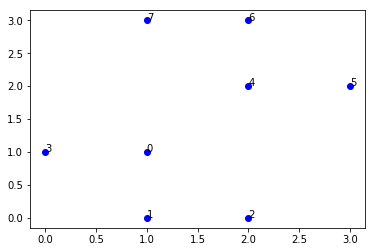

In [32]:
for s in range(state_count):
    print(s)
    plt.plot(state_map_grid[s][0], state_map_grid[s][1], color='b', marker='o')
    plt.annotate("%d"%s, xy=(state_map_grid[s][0], state_map_grid[s][1]))
plt.savefig("hello")

array([4.86501669e+06, 3.97165333e+01, 4.86489754e+06])